In [12]:
import os
import pandas as pd
import numpy as np
import pickle
import segregation
from segregation.dissimilarity import Dissim

In [39]:
os.chdir('C:/Users/renan/Desktop/full_count_2010')
census_2010 = pd.read_csv('std_2010_fullcount.csv', encoding = "ISO-8859-1", sep = ",")

with open('tracts_US.pkl', 'rb') as input:
    map_gpd = pickle.load(input)
    
df = census_2010.loc[(census_2010.county == "Los Angeles County")]

map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
gdf = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')

gdf['rel']   = np.where(gdf['pop10'] == 0, 0, gdf['nhblk10'] / gdf['pop10'])

Text(0.5,1,'Los Angeles Original Composition')

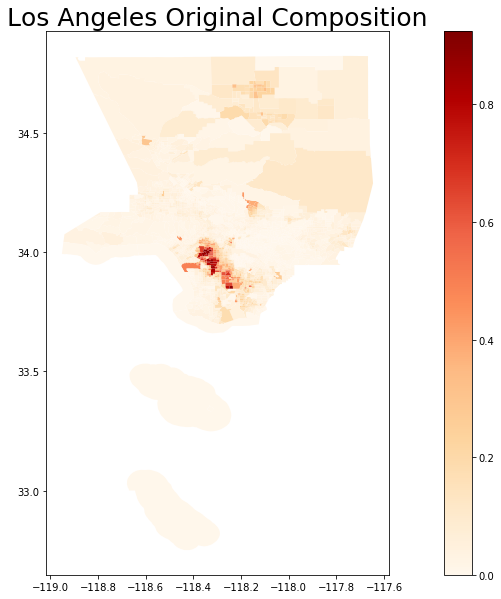

In [40]:
ax1 = gdf.plot(column = 'rel',
               cmap = 'OrRd', 
               figsize = (20,10),
               legend = True)
ax1.set_title("Los Angeles Original Composition", fontsize=25)

In [31]:
df_NY = census_2010.loc[(census_2010.county.isin(["New York County", 
                                               "Bronx County", 
                                               "Kings County", 
                                               "Queens County", 
                                               "Richmond County"])) & (census_2010.state == 'NY')]

In [41]:
ny_gdf_pre = map_gpd.merge(df_NY, left_on = 'INTGEOID10', right_on = 'trtid10')
ny_gdf = ny_gdf_pre[['geometry', 'pop10', 'nhblk10']]

ny_gdf['share'] = np.where(ny_gdf['pop10'] == 0, 0, ny_gdf['nhblk10'] / ny_gdf['nhblk10'].sum())
ny_gdf['rel']   = np.where(ny_gdf['pop10'] == 0, 0, ny_gdf['nhblk10'] / ny_gdf['pop10'])

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Text(0.5,1,'New York Original Composition')

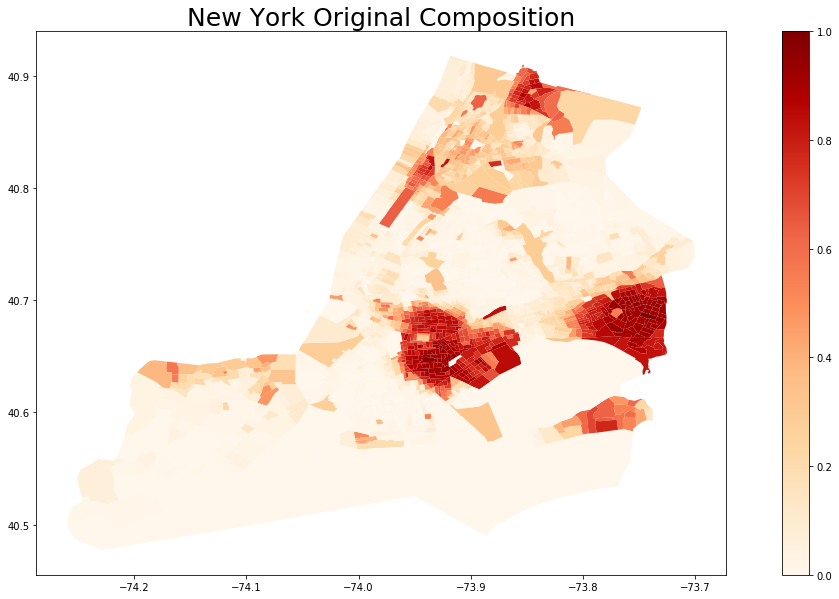

In [42]:
ax1 = ny_gdf.plot(column = 'rel',
                  cmap = 'OrRd', 
                  figsize = (20,10),
                  legend = True)
ax1.set_title("New York Original Composition", fontsize=25)

# Building LA and NY counter-factual

In [98]:
data_1 = gdf[['nhblk10', 'pop10', 'geometry']].copy()
data_2 = ny_gdf[['nhblk10', 'pop10', 'geometry']].copy()

data_1['group_pop_var'] = data_1['nhblk10']
data_1['total_pop_var'] = data_1['pop10']

data_2['group_pop_var'] = data_2['nhblk10']
data_2['total_pop_var'] = data_2['pop10']

In [99]:
data_1['rel'] = np.where(data_1['total_pop_var'] == 0, 0, data_1['group_pop_var'] / data_1['total_pop_var'])
data_2['rel'] = np.where(data_2['total_pop_var'] == 0, 0, data_2['group_pop_var'] / data_2['total_pop_var'])

# Both appends are to force both distribution to have values in all space between 0 and 1
x_1_pre = np.sort(data_1['rel'])
y_1_pre = np.arange(0, len(x_1_pre)) / (len(x_1_pre))

x_2_pre = np.sort(data_2['rel'])
y_2_pre = np.arange(0, len(x_2_pre)) / (len(x_2_pre))

x_1 = np.append(np.append(0, x_1_pre), 1)
y_1 = np.append(np.append(0, y_1_pre), 1)

x_2 = np.append(np.append(0, x_2_pre), 1)
y_2 = np.append(np.append(0, y_2_pre), 1)

def inverse_cdf_1(pct):
    return x_1[np.where(y_1 > pct)[0][0] - 1]

def inverse_cdf_2(pct):
    return x_2[np.where(y_2 > pct)[0][0] - 1]

# Adding the pseudo columns for FIRST spatial context
data_1['cumulative_percentage'] = (data_1['rel'].rank() - 1) / len(data_1) # It has to be a minus 1 in the rank, in order to avoid 100% percentile in the max
data_1['pseudo_rel'] = data_1['cumulative_percentage'].apply(inverse_cdf_2)
data_1['pseudo_group_pop_var'] = round(data_1['pseudo_rel'] * data_1['total_pop_var']).astype(int)

# Selecting just some columns to avoid confusion in the next step
data_1 = data_1[['pseudo_group_pop_var', 'total_pop_var', 'pseudo_rel', 'geometry']]

# Adding the pseudo columns for SECOND spatial context
data_2['cumulative_percentage'] = (data_2['rel'].rank() - 1) / len(data_2) # It has to be a minus 1 in the rank, in order to avoid 100% percentile in the max
data_2['pseudo_rel'] = data_2['cumulative_percentage'].apply(inverse_cdf_1)
data_2['pseudo_group_pop_var'] = round(data_2['pseudo_rel'] * data_2['total_pop_var']).astype(int)

# Selecting just some columns to avoid confusion in the next step
data_2 = data_2[['pseudo_group_pop_var', 'total_pop_var', 'pseudo_rel', 'geometry']]

In [100]:
data_1.head()

,pseudo_group_pop_var,total_pop_var,pseudo_rel,geometry
0,116,7027,0.016535,"POLYGON ((-118.540602 34.379708, -118.541289 3..."
1,128,2686,0.047574,"POLYGON ((-118.525017 34.446375, -118.524103 3..."
2,1274,1802,0.706981,"POLYGON ((-118.205608 33.790184, -118.205414 3..."
3,2992,4107,0.728509,"POLYGON ((-118.18975 33.844784, -118.189815 33..."
4,3192,4587,0.695889,"POLYGON ((-118.20485 33.881322, -118.204201 33..."


Text(0.5,1,'Los Angeles Counter-Factual Composition')

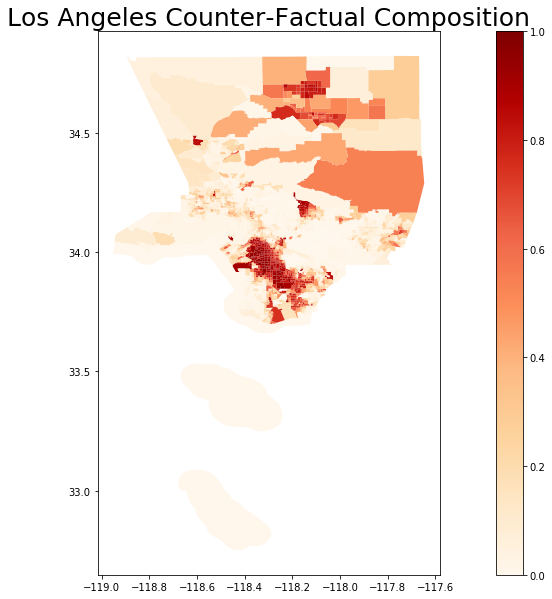

In [101]:
ax1 = data_1.plot(column = 'pseudo_rel',
               cmap = 'OrRd', 
               figsize = (20,10),
               legend = True)
ax1.set_title("Los Angeles Counter-Factual Composition", fontsize=25)

Text(0.5,1,'New York Counter-Factual Composition')

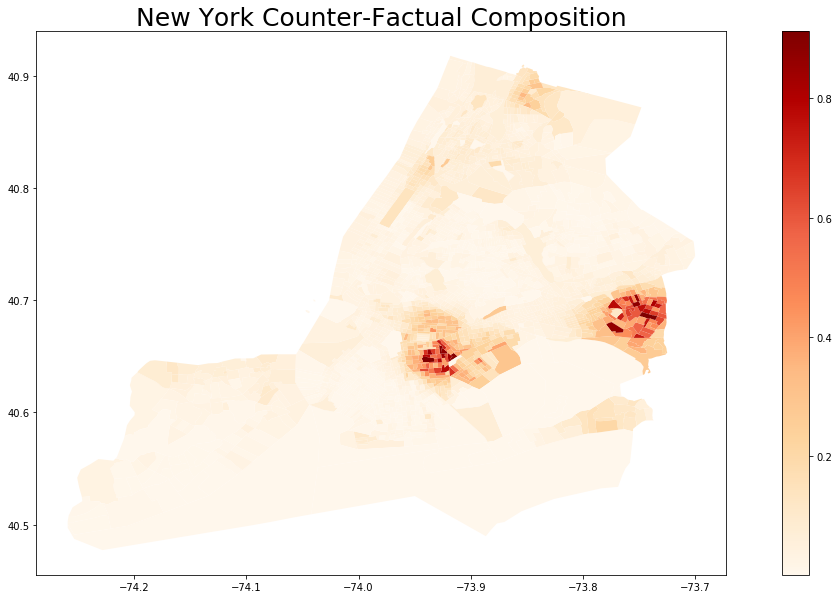

In [102]:
ax2 = data_2.plot(column = 'pseudo_rel',
               cmap = 'OrRd', 
               figsize = (20,10),
               legend = True)
ax2.set_title("New York Counter-Factual Composition", fontsize=25)

In [104]:
G_A = Dissim(gdf, 'nhblk10', 'pop10').statistic
G_D = Dissim(ny_gdf, 'nhblk10', 'pop10').statistic

G_B = Dissim(data_1, 'pseudo_group_pop_var', 'total_pop_var').statistic
G_C = Dissim(data_2, 'pseudo_group_pop_var', 'total_pop_var').statistic

c:\users\renan\desktop\segregation\segregation\dissimilarity.py:61: RuntimeWarning: invalid value encountered in true_divide
  pi = np.where(t == 0, 0, x / t)


In [105]:
G_D - G_A

0.12176976787341487